In [1]:
import pandas as pd
import numpy as np
import math
import datetime as datetime
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('FixedLatLongTimeLoc.csv')

/home/march/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data['DATE_TIME'] =  pd.to_datetime(data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

In [4]:
data.head()

,Unnamed: 0,CALL_NO,UNIT_DISPATCH_DATE,DISPATCH_TIME,CALL_TYPE_FINAL,CALL_TYPE_FINAL_D,XCOORD,YCOORD,DATE_TIME
0,0,61209515,2006-12-28,44548,773A,UNCONSCIOUS PERS,39.824332,-86.236119,2006-12-28 04:45:48
1,1,61209516,2006-12-28,44853,774A,ASSAULT/TRAUMA,39.781627,-86.120826,2006-12-28 04:48:53
2,2,61209517,2006-12-28,45219,768A,SEIZURE,39.756840,-85.998714,2006-12-28 04:52:19
3,3,61209519,2006-12-28,51057,773A,UNCONSCIOUS PERS,39.782064,-86.044592,2006-12-28 05:10:57
4,4,61209520,2006-12-28,51756,790A,*MEDICAL ALARM,39.742415,-86.111559,2006-12-28 05:17:56


Text(0.5,1,'Gridded Event Locations')

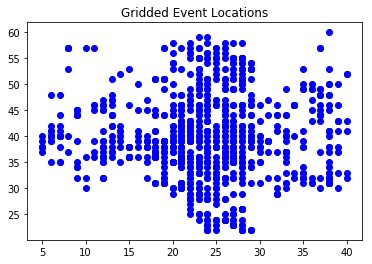

In [17]:
def assign_to_grid(xcord, ycord, xgridsize, ygridsize, xmin, xrange, ymin, yrange):
    # Assign a lat and long coordinate to a grid location. Input xcord, ycord as lat/long to be mapped
    # gridsize is dimension of matrix
    # min is smallest lat/long coordinate, range is max(xcoordinate) - min(xcoordinate) and repeat for y
    
    xbin = int((xcord-xmin)/(xmax-xmin)*xgridsize)
    ybin = int((ycord-ymin)/(ymax-ymin)*ygridsize)
    return xbin, ybin

#xmax =  data['XCOORD'].max()
#xmin =  data['XCOORD'].min()
#xrange = xmax-xmin
#ymax =  data['YCOORD'].max()
#ymin =  data['YCOORD'].min()
#yrange = ymax-ymin

#xgridsize = 50
#ygridsize = int(xgridsize*yrange/xrange)

#points = []
#for i in range(0, 1000):
#    point = assign_to_grid(data['XCOORD'][i], data['YCOORD'][i], xgridsize, ygridsize, xmin, xrange, ymin, yrange)
#    points.append(point)
#plt.plot(*zip(*points), marker='o', color='b', ls='')
#plt.title("Gridded Event Locations")

In [20]:
def event_update(mu_g, Lam_g, time_delta_last_g_time, theta, w, F_g, time_delta_last_time):
# update mu, theta and triggering exponentials for grids where event occurred
    dt = time_delta_last_time
    mu_g = mu_g + dt * (mu_g/Lam_g-mu_g*time_delta_last_g_time)
    for k in range(0, len(w)):
        theta[k] = theta[k] + dt * (F_g[k]/Lam_g-theta[k])
        F_g[k] = F_g[k] + w[k] * theta[k]
        
    return mu_g, theta, F_g

In [21]:
def global_update(F_xy, w, time_delta_last_time, theta, mu_xy):
# Decay triggering exponentials and calculate current intensities for all grids
    for k in range(0, len(w)):
        F_xy[k] = F_xy[k] * np.exp(-1*w[k]*time_delta_last_time)
    Lam_xy = mu_xy+sum(F_xy)
    
    return F_xy, Lam_xy

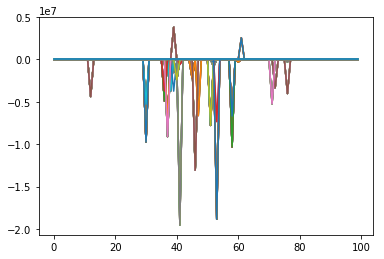

In [115]:
xmax =  data['XCOORD'].max()
xmin =  data['XCOORD'].min()
xrange = xmax-xmin
ymax =  data['YCOORD'].max()
ymin =  data['YCOORD'].min()
yrange = ymax-ymin

xgridsize = 100
ygridsize = int(xgridsize*xrange/yrange)

w = [.5, .1, .05]
theta = [0, 0, 0]

events = 30

mu = np.ones([xgridsize, ygridsize])*.1
F = np.ones([xgridsize, ygridsize, len(w)])
Lam = np.ones([xgridsize, ygridsize, events])*0.5

G_times = np.zeros([xgridsize, ygridsize])
G_times = pd.DataFrame(G_times)

for i in range(1, events):
    # assign event to a grid
    [gx, gy] = assign_to_grid(data.XCOORD[i], data.YCOORD[i], xgridsize, ygridsize, xmin, xrange, ymin, yrange)
    
    # time since last event in any grid box. Divide by 100 to prevent overflow
    time_delta = (data.DATE_TIME[i]- data.DATE_TIME[i-1]).total_seconds()/100
    
    # update intensities for all grid boxes
    for x in range(xgridsize):
        for y in range(ygridsize):
            [F[x][y], Lam[x][y][i]] = global_update(F[x][y], w, time_delta, theta, mu[x][y]) 
    # find last time event occurred at this grid location
    last_g_time = pd.to_datetime(G_times.loc[(gx),(gy)])
    # find delta between last event time and current time. Divide by 100 to prevent overflow
    g_time_delta = (data.DATE_TIME[i] - last_g_time).total_seconds()/100
    # update event time for this location
    G_times.at[gx,gy] = data.DATE_TIME[i]
    
    # update model parameters for grid where event happened
    [mu[gx][gy], theta, F[gx][gy]] = event_update(mu[gx][gy], Lam[gx][gy][i], g_time_delta, theta, w, F[gx][gy], time_delta)


